In [37]:
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Upload the model files (prototxt, caffemodel, npy)

In [38]:
print("Upload the model files:")
uploaded = files.upload()

Upload the model files:


Saving colorization_deploy_v2.prototxt to colorization_deploy_v2 (3).prototxt
Saving colorization_release_v2.caffemodel to colorization_release_v2 (3).caffemodel
Saving pts_in_hull.npy to pts_in_hull (3).npy


## Store the file names from the uploaded dictionary

In [40]:
for filename in uploaded.keys():
    if filename.endswith(".prototxt"):
        PROTOTXT = filename
    elif filename.endswith(".npy"):
        POINTS = filename
    elif filename.endswith(".caffemodel"):
        MODEL = filename


# Load the model

In [41]:
print("Loading model...")
net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
pts = np.load(POINTS)

Loading model...


# Set the layers for quantization

In [42]:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

# Upload the image file

In [43]:
print("Upload the image file:")
uploaded_image = files.upload()

Upload the image file:


Saving flower.jpeg to flower (3).jpeg
Saving garden.jpeg to garden (3).jpeg
Saving nature.jpeg to nature (3).jpeg
Saving waterfall.jpg to waterfall (3).jpg


In [44]:
original_images = []
colorized_images = []

# Process the uploaded image

In [45]:
for image_filename in uploaded_image.keys():
    # Read the uploaded image
    image = cv2.imread(image_filename)
    scaled = image.astype("float32") / 255.0
    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)


# Resize the image

In [46]:
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50


# Colorizing the image

In [47]:
print(f"Colorizing image: {image_filename}...")
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

Colorizing image: waterfall (3).jpg...


# Resize the ab channels back to the original image size


In [48]:
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

# Combine with the original L channel

In [49]:
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

# Convert back to BGR color space

In [50]:
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")

In [51]:
original_images.append(image)
colorized_images.append(colorized)

# Display the original and colorized images

In [55]:
num_images = len(original_images)
plt.figure(figsize=(15, num_images * 5))




<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

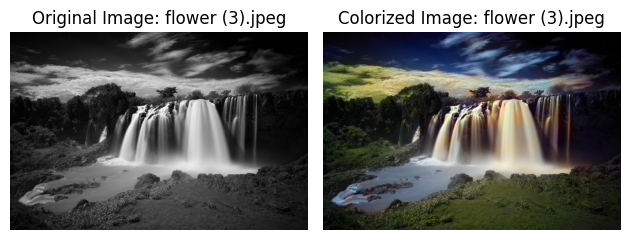

In [56]:
for i in range(num_images):
    plt.subplot(num_images, 2, i * 2 + 1)
    plt.imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image: {list(uploaded_image.keys())[i]}")
    plt.axis('off')

    plt.subplot(num_images, 2, i * 2 + 2)
    plt.imshow(cv2.cvtColor(colorized_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Colorized Image: {list(uploaded_image.keys())[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()